In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")

In [4]:
df.columns = ["label", "time", "date", "query", "username", "text"]

In [5]:
df.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
len(df), df.shape

(1599999, (1599999, 6))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

In [9]:
df.isnull().sum()

label       0
time        0
date        0
query       0
username    0
text        0
dtype: int64

In [10]:
df = df[['text','label']]

In [11]:
df.head()

,text,label
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [12]:
df.label.unique()

array([0, 4])

In [13]:
df['label'][df['label']==4]=1

In [14]:
df.label.unique()

array([0, 1])

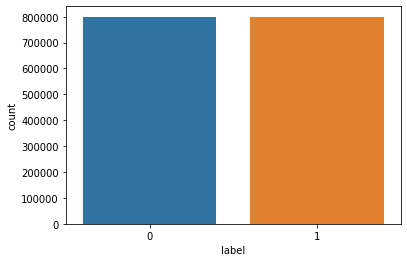

In [16]:
sns.countplot(df['label'])

In [17]:
pos_tweets = df[df['label'] == 1]
neg_tweets = df[df['label'] == 0]


In [18]:
pos_tweets = pos_tweets.iloc[:int(20000)]
neg_tweets = neg_tweets.iloc[:int(20000)]

In [19]:
df = pd.concat([pos_tweets, neg_tweets])
df.head()

,text,label
799999,I LOVE @Health4UandPets u guys r the best!!,1
800000,im meeting up with one of my besties tonight! ...,1
800001,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800002,Being sick can be really cheap when it hurts t...,1
800003,@LovesBrooklyn2 he has that effect on everyone,1


In [20]:
df.head(), df.tail()

(                                                     text  label
 799999       I LOVE @Health4UandPets u guys r the best!!       1
 800000  im meeting up with one of my besties tonight! ...      1
 800001  @DaRealSunisaKim Thanks for the Twitter add, S...      1
 800002  Being sick can be really cheap when it hurts t...      1
 800003    @LovesBrooklyn2 he has that effect on everyone       1,
                                                     text  label
 19995                          One more day of holidays       0
 19996  feeling so down right now .. i hate you DAMN H...      0
 19997  geez,i hv to READ the whole book of personalit...      0
 19998  I threw my sign at donnie and he bent over to ...      0
 19999  @heather2711 Good thing I didn't find any then...      0)

In [21]:
df['text'] = df['text'].str.lower()

In [22]:
nltk.download('stopwords')
list_of_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
STOPWORDS = set(stopwords.words('english'))

In [24]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [25]:
df['text'] = df['text'].apply(lambda text: remove_stopwords(text))

In [26]:
df['text'].tail()

19995                                     one day holidays
19996                   feeling right .. hate damn humprey
19997    geez,i hv read whole book personality types em...
19998     threw sign donnie bent get thingee made sad face
19999    @heather2711 good thing find none ones like co...
Name: text, dtype: object

In [27]:
punc = string.punctuation

In [40]:
def remove_punctuations(text):
    translator = str.maketrans('', '', punc)
    return text.translate(translator)

In [41]:
df['text']= df['text'].apply(lambda x: remove_punctuations(x))
df['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

In [42]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [43]:
df['text'] = df['text'].apply(lambda x: remove_repeating_char(x))
df['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [44]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [45]:
df['text']= df['text'].apply(lambda x: cleaning_email(x))
df['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [46]:
def remove_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [47]:
df['text'] = df['text'].apply(lambda x: remove_URLs(x))
df['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [48]:
def remove_numbers(data):
    return re.sub('[0-9]+', '', data)

In [49]:
df['text'] = df['text'].apply(lambda x: remove_numbers(x))
df['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather god thing find none ones like come siz...
Name: text, dtype: object

In [50]:
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)

In [51]:
df['text']

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
                                ...                        
19995                                  [one, day, holidays]
19996                  [feling, right, hate, damn, humprey]
19997     [gezi, hv, read, whole, bok, personality, type...
19998     [threw, sign, donie, bent, get, thinge, made, ...
19999     [heather, god, thing, find, none, ones, like, ...
Name: text, Length: 40000, dtype: object

In [52]:
st = nltk.PorterStemmer()
def stemming_on_text(df):
    text = [st.stem(word) for word in df]
    return df

df['text']= df['text'].apply(lambda x: stemming_on_text(x))

In [53]:
df['text']

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
                                ...                        
19995                                  [one, day, holidays]
19996                  [feling, right, hate, damn, humprey]
19997     [gezi, hv, read, whole, bok, personality, type...
19998     [threw, sign, donie, bent, get, thinge, made, ...
19999     [heather, god, thing, find, none, ones, like, ...
Name: text, Length: 40000, dtype: object

In [55]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [56]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(df):
    text = [lm.lemmatize(word) for word in df]
    return df

df['text'] = df['text'].apply(lambda x: lemmatizer_on_text(x))

In [57]:
df['text']

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
                                ...                        
19995                                  [one, day, holidays]
19996                  [feling, right, hate, damn, humprey]
19997     [gezi, hv, read, whole, bok, personality, type...
19998     [threw, sign, donie, bent, get, thinge, made, ...
19999     [heather, god, thing, find, none, ones, like, ...
Name: text, Length: 40000, dtype: object

In [58]:
#MODEL

In [59]:
X=df.text
y=df.label

In [60]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [61]:
sequences_matrix.shape

(40000, 500)

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [63]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [64]:
def tensorflow_based_model(): 
    inputs = Input(name='inputs',shape=[max_len])

    layer = Embedding(2000,50,input_length=max_len)(inputs) 
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer)
    return model 

In [65]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

In [67]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)

Epoch 1/6
315/315 [==============================] - 128s 407ms/step - loss: 0.4511 - accuracy: 0.7815 - val_loss: 0.5491 - val_accuracy: 0.7429
Epoch 2/6
315/315 [==============================] - 129s 411ms/step - loss: 0.4388 - accuracy: 0.7907 - val_loss: 0.5618 - val_accuracy: 0.7357
Epoch 3/6
315/315 [==============================] - 128s 405ms/step - loss: 0.4278 - accuracy: 0.7947 - val_loss: 0.5686 - val_accuracy: 0.7264
Epoch 4/6
315/315 [==============================] - 127s 404ms/step - loss: 0.4209 - accuracy: 0.8007 - val_loss: 0.5695 - val_accuracy: 0.7196
Epoch 5/6
315/315 [==============================] - 129s 409ms/step - loss: 0.4094 - accuracy: 0.8069 - val_loss: 0.5743 - val_accuracy: 0.7221
Epoch 6/6
315/315 [==============================] - 128s 406ms/step - loss: 0.3983 - accuracy: 0.8148 - val_loss: 0.6196 - val_accuracy: 0.7211


In [73]:
model.evaluate(X_test,Y_test)

375/375 [==============================] - 24s 63ms/step - loss: 0.6023 - accuracy: 0.7328


[0.6022859811782837, 0.7328333258628845]

In [68]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) 

In [69]:
CR=confusion_matrix(Y_test, y_pred)

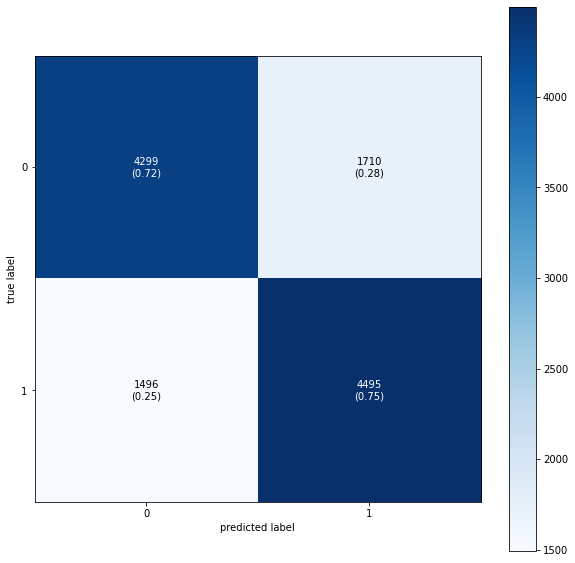

In [70]:
fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [71]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      6009
           1       0.72      0.75      0.74      5991

    accuracy                           0.73     12000
   macro avg       0.73      0.73      0.73     12000
weighted avg       0.73      0.73      0.73     12000

